<h1>Chapter 08. Dimensionality Reduction</h1>

Dimensionality reduction is a technique used in machine learning and data analysis to reduce the number of input variables or features in a dataset while preserving essential information. It aims to simplify complex datasets by transforming them into a lower-dimensional space, making them more manageable for analysis and modeling. Dimensionality reduction methods seek to retain as much relevant information as possible while reducing the computational complexity and noise in the data, facilitating tasks such as visualization, clustering, and classification. Popular techniques include Principal Component Analysis (PCA), t-Distributed Stochastic Neighbor Embedding (t-SNE), and Linear Discriminant Analysis (LDA).

<h2>PCA</h2>

PCA (Principal Component Analysis) is a dimensionality reduction technique that simplifies high-dimensional datasets by identifying and representing patterns using fewer variables while preserving essential information.

Simple 3D dataset

In [1]:
import numpy as np


np.random.seed(4)

m = 60  # number of samples

# Define weights and noise level
w1, w2 = 0.1, 0.3
noise = 0.1

# Generate random angles
angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5

# Create an empty array to store data
X = np.empty((m, 3))

# Generate features using trigonometric functions and noise
X[:, 0] = np.cos(angles) + np.sin(angles) / 2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

<h3>Principal Components</h3>

Principal Components (PCs) are the main underlying patterns in data discovered through PCA, representing directions of maximum variance. They provide a new coordinate system where each component is a combination of original features. PCs aid in dimensionality reduction, visualization, and data compression.

In [2]:
X_centered = X - X.mean(axis=0)

# Perform Singular Value Decomposition (SVD) on the centered data
U, s, Vt = np.linalg.svd(X_centered)

c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [3]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [4]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

<h3>Projecting down to <i>d</i> Dimensions</h3>

Projecting down to `d` dimensions involves transforming high-dimensional data into a lower-dimensional space while preserving essential information.

In [5]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [6]:
X2D_using_svd = X2D

<h3>Using Scikit-Learn</h3>

`PCA` (Principal Component Analysis) from scikit-learn is a dimensionality reduction technique that identifies the main patterns in data, allowing for the transformation of high-dimensional datasets into a lower-dimensional space while retaining critical information.

With Scikit-Learn, `PCA` is really trivial. It even takes care of mean centering

In [7]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [8]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [9]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

Running `PCA` multiple times on slightly different datasets may result in different results. In general the only difference is that some axes may be flipped. In this example, `PCA` using Scikit-Learn gives the same projection as the one given by the SVD approach, except both axes are flipped:

In [10]:
np.allclose(X2D, -X2D_using_svd)

True

Recover the 3D points projected on the plane (PCA 2D subspace)

In [11]:
X3D_inv = pca.inverse_transform(X2D)

There was some loss of information during the projection step, so the recovered 3D points are not exactly equal to the original 3D points

In [12]:
np.allclose(X3D_inv, X)

False

Reconstruction error calculation

In [13]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.01017033779284855

The inverse transform in the SVD approach

In [14]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

The reconstructions from both methods differ because Scikit-Learn's `PCA` class automatically handles reversing the mean centering. However, subtracting the mean manually results in identical reconstruction.

In [15]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

The `PCA` object gives access to the principal components that it computed

In [16]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

<h3>Explained Variance Ratio</h3>

Explained Variance Ratio quantifies the proportion of dataset variance captured by each principal component in `PCA`, aiding in understanding the significance of individual components for data representation and dimensionality reduction.

In [17]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [18]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

The result suggests that 84.2% of the variance of the dataset lies along the first axis, and 14.6% lies along the second axis. The third axis remains less than 1.2%, which means it carries little information.

<h3>Choosing the Right Number of Dimensions</h3>

Instead of choosing an arbitrary number of dimensions to lower the dimensionality, it is usually preferable to choose a number of dimensions that corresponds to a sufficiently large portion of the variance (95%).

In [19]:
from sklearn.datasets import fetch_openml


mnist = fetch_openml(
    'mnist_784',
    version=1,
    as_frame=False,
    parser='auto'
)
mnist.target = mnist.target.astype(np.uint8)

In [20]:
from sklearn.model_selection import train_test_split


X = mnist['data']
y = mnist['target']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [21]:
pca = PCA()
pca.fit(X_train)

cumsum = np.cumsum(pca.explained_variance_ratio_)

# Determine the number of dimensions to retain where cumulative explained variance ratio exceeds 0.95
d = np.argmax(cumsum >= 0.95) + 1

In [22]:
d

154

Plotting explained variance as a function of the number of dimensions

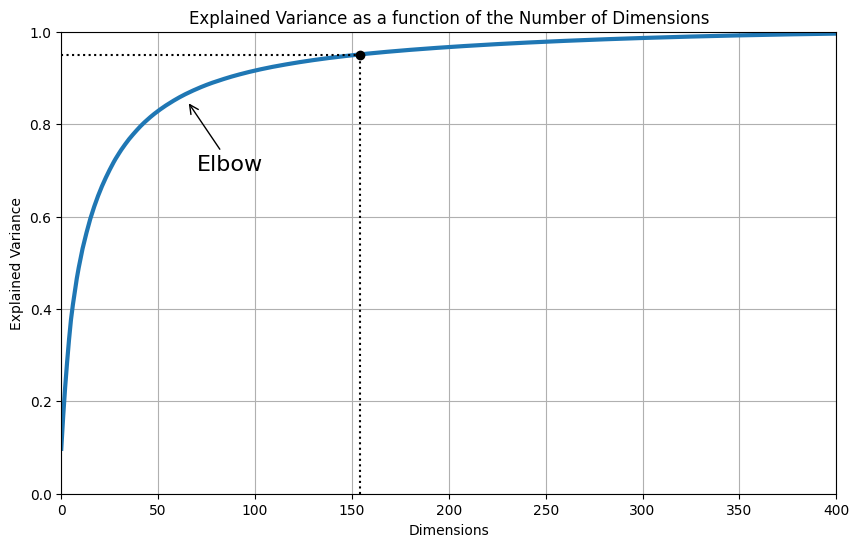

In [23]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel('Dimensions')
plt.ylabel('Explained Variance')
plt.plot(
    [d, d],
    [0, 0.95],
    'k:'
)
plt.plot(
    [0, d],
    [0.95, 0.95],
    'k:'
)
plt.plot(
    d,
    0.95,
    'ko'
)
plt.annotate(
    'Elbow',
    xy=(65, 0.85),
    xytext=(70, 0.7),
    arrowprops=dict(arrowstyle='->'),
    fontsize=16
)
plt.title('Explained Variance as a function of the Number of Dimensions')
plt.grid(True)
plt.show()

A superior alternative exists: instead of explicitly defining the number of principal components for fusion, you can specify n_components as a floating-point value between 0.0 and 1.0, representing the desired fraction of variance to be incorporated.

In [24]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [25]:
pca.n_components_

154

In [26]:
np.sum(pca.explained_variance_ratio_)

0.9503684424557436

<h3>PCA for Compression</h3>

PCA for compression reduces the size of high-dimensional datasets while preserving essential information, making it effective for data compression.

In [27]:
pca = PCA(n_components=154)

X_reduced = pca.fit_transform(X_train)

# Transform the reduced-dimensional data back into the original feature space
X_recovered = pca.inverse_transform(X_reduced)

Plotting MNIST compression that preserves 95% of the variance

In [28]:
import matplotlib as mpl


def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)

    # This is equivalent to n_rows = ceil(len(inisinstance) / image_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28x28 images
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transponse(), and only then we
    # can reshape
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size, images_per_row * size)

    # Now that we have a big image, we just need to show it
    plt.imshow(
        big_image,
        cmap=mpl.cm.binary,
        **options
    )
    plt.axis('off')

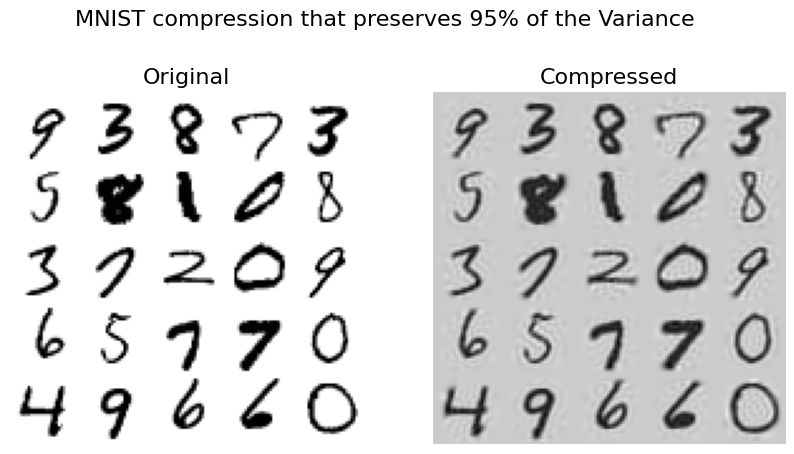

In [29]:
plt.figure(figsize=(10, 7))

plt.subplot(121)
plot_digits(instances=X_train[::2100])
plt.title('Original', fontsize=16)

plt.subplot(122)
plot_digits(instances=X_recovered[::2100])
plt.title('Compressed', fontsize=16)

plt.figtext(
    0.5,
    0.85,
    'MNIST compression that preserves 95% of the Variance',
    va='center',
    ha='center',
    fontsize=16
)
plt.show()

<h3>Randomized PCA</h3>

Randomized PCA accelerates computation of principal components for large datasets using randomized algorithms, maintaining accuracy while reducing complexity.

In [30]:
rnd_pca = PCA(
    n_components=154,
    svd_solver='randomized',
    random_state=42
)
X_reduced = rnd_pca.fit_transform(X_train)

<h3>Incremental PCA</h3>

`IncrementalPCA` enables efficient processing of large datasets by dividing them into manageable mini-batches. It computes the principal components incrementally, updating the solution with each mini-batch, making it suitable for datasets that do not fit into memory. `IncrementalPCA` allows for memory-efficient dimensionality reduction and preserves the characteristics of traditional PCA.

In [31]:
from sklearn.decomposition import IncrementalPCA


n_batches = 100

inc_pca = IncrementalPCA(n_components=154)

for X_batch in np.array_split(X_train, n_batches):  # array_split() splits dataset into n_batches
    inc_pca.partial_fit(X_batch)  # partial_fit() fits the model to each mini-batch

X_reduced = inc_pca.transform(X_train)

In [32]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

Verification that the comparison still works well

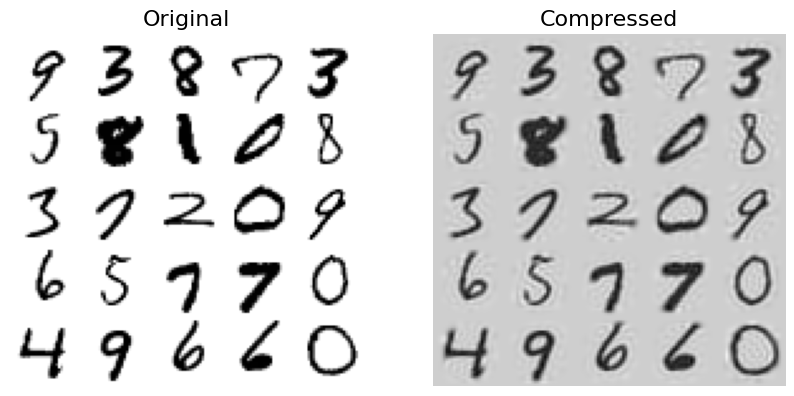

In [33]:
plt.figure(figsize=(10, 7))

plt.subplot(121)
plot_digits(instances=X_train[::2100])
plt.title('Original', fontsize=16)

plt.subplot(122)
plot_digits(instances=X_recovered_inc_pca[::2100])
plt.title('Compressed', fontsize=16)

plt.show()

Comparing the results of transforming MNIST using regular PCA and incremental PCA reveals that their means are equal.

In [34]:
np.allclose(pca.mean_, inc_pca.mean_)

True

**Using `memmap()`:**

`memmap()` is a function in Python's NumPy library used to create a memory-mapped array, allowing efficient access to large datasets stored on disk. It maps a file on disk into memory, enabling data manipulation as if it were entirely loaded into memory. Memory-mapped arrays facilitate working with datasets larger than available RAM, as only portions of the data are loaded into memory as needed. This function is particularly useful for handling large datasets that cannot fit into memory entirely.

In [35]:
filename = 'my_mnist.data'
m, n = X_train.shape

X_mm = np.memmap(
    filename,
    dtype='float32',
    mode='write',
    shape=(m, n)
)

X_mm[:] = X_train

Now deleting the memmap() object will trigger its Python finalizer, which ensures that the data is saved to disk

In [36]:
del X_mm

Next, another program would load the data and use it for training

In [37]:
X_mm = np.memmap(
    filename,
    dtype="float32",
    mode="readonly",
    shape=(m, n)
)

batch_size = m // n_batches

inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

**Time complexity:**

Regular PCA, Incremental PCA, and Randomized PCA are timed against each other for various numbers of principal components.

In [38]:
from time import time


for n_components in (2, 10, 154):
    print(f"n_components = {n_components}")
    
    regular_pca = PCA(
        n_components=n_components,
        svd_solver='full'  # svd_solver 'full' method for accurate decomposition
    )
    inc_pca = IncrementalPCA(
        n_components=n_components,
        batch_size=500
    )
    rnd_pca = PCA(
        n_components=n_components,
        svd_solver='randomized',
        random_state=42
    )

    for name, pca in (
        ('PCA', regular_pca),
        ('Inc PCA', inc_pca),
        ('Rnd PCA', rnd_pca)
    ):
        t1 = time()
        pca.fit(X_train)

        t2 = time()
        print(f"   {name}: {t2 - t1:.1f} seconds")

n_components = 2
   PCA: 8.1 seconds
   Inc PCA: 13.2 seconds
   Rnd PCA: 1.6 seconds
n_components = 10
   PCA: 8.1 seconds
   Inc PCA: 14.4 seconds
   Rnd PCA: 2.4 seconds
n_components = 154
   PCA: 8.9 seconds
   Inc PCA: 21.4 seconds
   Rnd PCA: 5.1 seconds


Comparing PCA and Randomized PCA for datasets of varying sizes (number of instances).

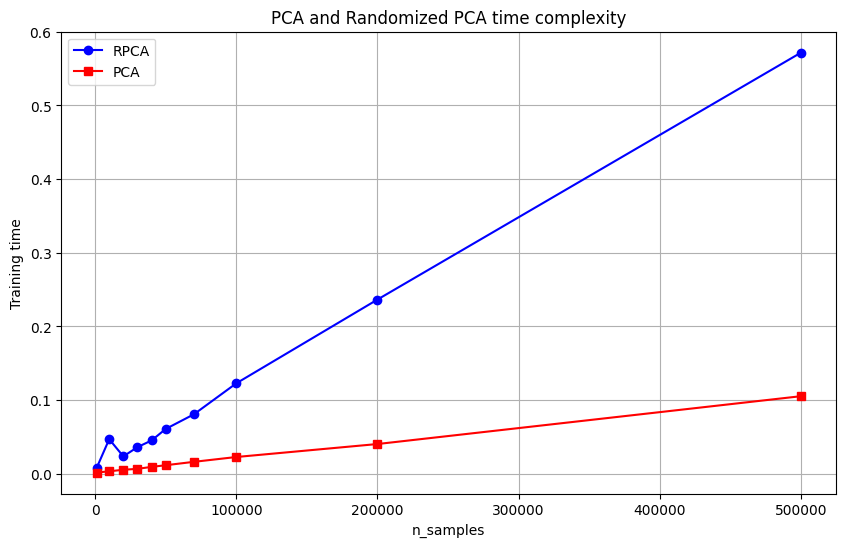

In [39]:
times_rpca = []
times_pca = []
sizes = [
    1000,
    10000,
    20000,
    30000,
    40000,
    50000,
    70000,
    100000,
    200000,
    500000
]

for n_samples in sizes:
    X = np.random.randn(n_samples, 5)

    pca = PCA(
        n_components=2,
        svd_solver='randomized',
        random_state=42
    )
    t1 = time()
    pca.fit(X)
    t2 = time()
    times_rpca.append(t2 - t1)

    pca = PCA(
        n_components=2,
        svd_solver='full'
    )
    t1 = time()
    pca.fit(X)
    t2 = time()
    times_pca.append(t2 - t1)

plt.figure(figsize=(10, 6))

plt.plot(
    sizes,
    times_rpca,
    'b-o',
    label='RPCA',
)
plt.plot(
    sizes,
    times_pca,
    'r-s',
    label='PCA'
)
plt.xlabel('n_samples')
plt.ylabel('Training time')
plt.legend(loc='upper left')
plt.title('PCA and Randomized PCA time complexity')
plt.grid(True)
plt.show()

Their performance is compared on datasets comprising 2,000 instances with different numbers of features

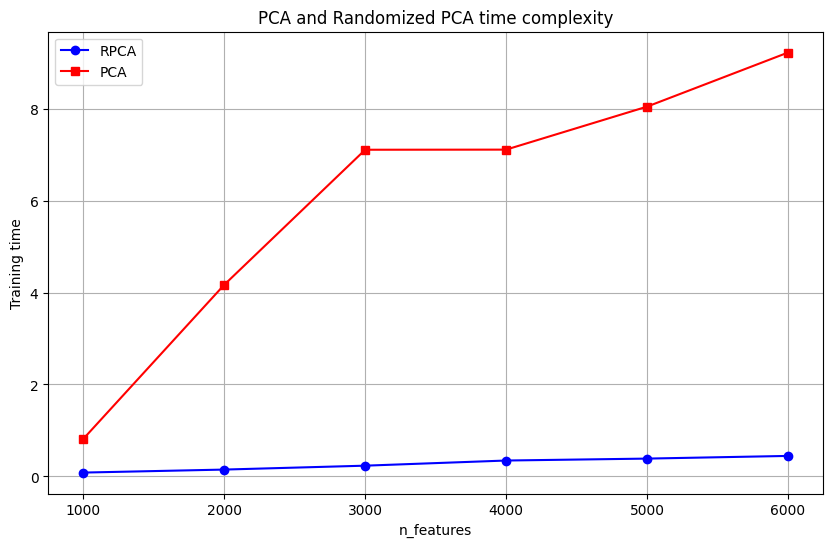

In [40]:
times_rpca = []
times_pca = []
sizes = [
    1000,
    2000,
    3000,
    4000,
    5000,
    6000
]

for n_features in sizes:
    X = np.random.randn(2000, n_features)

    pca = PCA(
        n_components=2,
        svd_solver='randomized',
        random_state=42
    )
    t1 = time()
    pca.fit(X)
    t2 = time()
    times_rpca.append(t2 - t1)

    pca = PCA(
        n_components=2,
        svd_solver='full'
    )
    t1 = time()
    pca.fit(X)
    t2 = time()
    times_pca.append(t2 - t1)

plt.figure(figsize=(10, 6))

plt.plot(
    sizes,
    times_rpca,
    'b-o',
    label='RPCA',
)
plt.plot(
    sizes,
    times_pca,
    'r-s',
    label='PCA'
)
plt.xlabel('n_features')
plt.ylabel('Training time')
plt.legend(loc='upper left')
plt.title('PCA and Randomized PCA time complexity')
plt.grid(True)
plt.show()

<h2>Kernel PCA</h2>

KernelPCA (Kernel Principal Component Analysis) is a nonlinear dimensionality reduction technique that extends the traditional PCA method by incorporating kernel functions. It projects high-dimensional data into a lower-dimensional space while preserving the nonlinear structure of the data. This is achieved by mapping the data into a higher-dimensional space where it can be linearly separated, and then applying PCA in that space. 

In [41]:
from sklearn.datasets import make_swiss_roll


X, t = make_swiss_roll(
    n_samples=1000,
    noise=0.2,
    random_state=42
)

In [42]:
from sklearn.decomposition import KernelPCA


rbf_pca = KernelPCA(
    n_components=2,
    kernel='rbf',
    gamma=0.04
)
X_reduced = rbf_pca.fit_transform(X)

Plotting swiss roll reduced to 2D using kPCA with various kernels

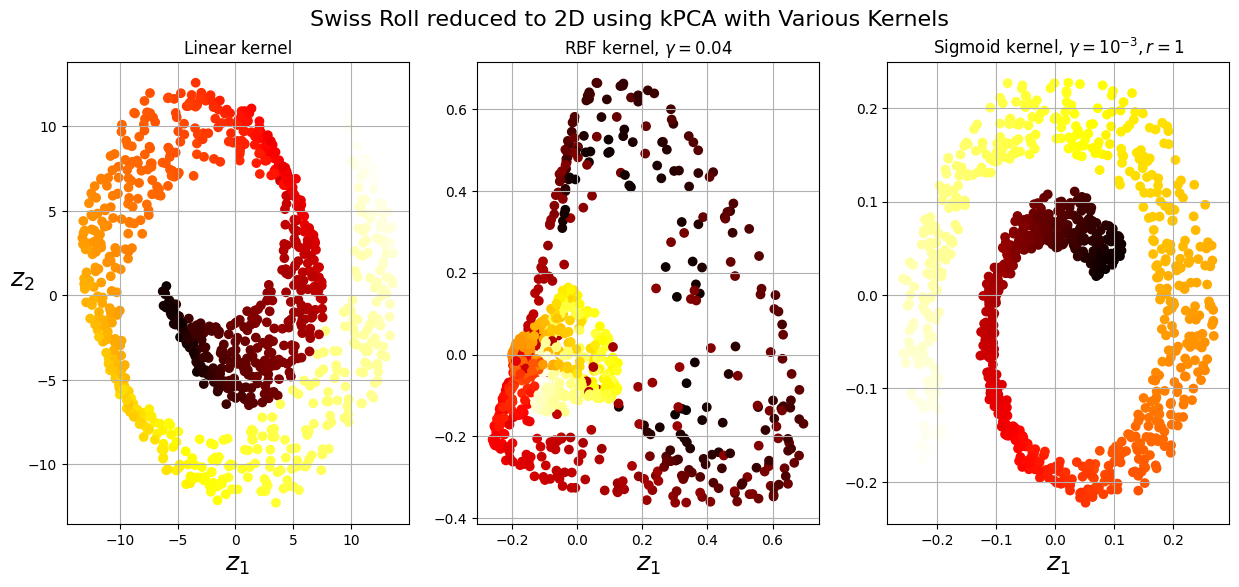

In [43]:
# Initialize KernelPCA with linear kernel for linear dimensionality reduction
lin_pca = KernelPCA(
    n_components=2,
    kernel='linear',
    fit_inverse_transform=True
)

# Initialize KernelPCA with radial basis function (RBF) kernel for nonlinear dimensionality reduction
rbf_pca = KernelPCA(
    n_components=2,
    kernel='rbf',
    fit_inverse_transform=True,
    gamma=0.0433
)

# Initialize KernelPCA with sigmoid kernel for nonlinear dimensionality reduction
sig_pca = KernelPCA(
    n_components=2,
    kernel='sigmoid',
    fit_inverse_transform=True,
    gamma=0.001,
    coef0=1
)

y = t > 6.9

plt.figure(figsize=(15, 6))

for subplot, pca, title in (
    (131, lin_pca, 'Linear kernel'),
    (132, rbf_pca, r'RBF kernel, $\gamma=0.04$'),
    (133, sig_pca, r'Sigmoid kernel, $\gamma=10^{-3}, r=1$')
):
    X_reduced = pca.fit_transform(X)

    if subplot == 132:
        X_reduced_rbf = X_reduced

    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(
        X_reduced[:, 0],
        X_reduced[:, 1],
        c=t,
        cmap=plt.cm.hot
    )
    plt.xlabel('$z_1$', fontsize=18)

    if subplot == 131:
        plt.ylabel('$z_2$', fontsize=18, rotation=0)

    plt.grid(True)

plt.figtext(
    0.5,
    0.95,
    'Swiss Roll reduced to 2D using kPCA with Various Kernels',
    ha='center',
    va='center',
    fontsize=16
)
plt.show()

<h3>Selecting a Kernel and Tuning Hyperparameters</h3>

This code creates a two-step pipeline, first downscaling to two dimensions using kPCA and then using logistic regression for classification. It then uses the GridSearchCV class to find the best kernel and gamma value for kPCA to achieve the highest classification accuracy at the end of the pipeline.

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


# Create a pipeline combining KernelPCA and LogisticRegression
clf = Pipeline([
    ('kpca', KernelPCA(n_components=2)),
    ('log_reg', LogisticRegression(solver='lbfgs'))
])

# Define the parameter for GridSearchCV
param_grid = [{
    'kpca__gamma': np.linspace(0.03, 0.05, 10),  # range of gamma values for KernelPCA
    'kpca__kernel': ['rbf', 'sigmoid']  # kernel types for KernelPCA
}]

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    clf,  # pipeline to be optimizea
    param_grid,  # parameter grid to search
    cv=3  # number of cross-validation folds
)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [45]:
grid_search.best_params_  # get best kernel and hyperparameters

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}

A pre-image in KernelPCA is an approximation of the original data point in the input space from its reduced-dimensional representation. It helps understand how the data looks in the original space after transformation.

In [46]:
rbf_pca = KernelPCA(
    n_components=2,
    kernel='rbf',
    gamma=0.0433,
    fit_inverse_transform=True
)

X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

Calculate the recovery pre-image error

In [47]:
from sklearn.metrics import mean_squared_error


mean_squared_error(X, X_preimage)

32.786308795766075